# Modular TensorFlow model with 2D embedding - Train and save models

*Embedding* converts a categorical variable into a projection onto n-dimensional space [1], and has been shown to be an effective way to train neural network when using categorical data, while also allowing a measure of similarity/distance between different values of the categorical data, Here we use embedding for hospital ID. We also convert patient data and pathway data into an embedded vector (this may also be known as *encoding* the data in a vector with fewer dimensions than the original data set for those groups of features).

[1] Guo C, & Berkhahn F. (2016) Entity Embeddings of Categorical Variables. arXiv:160406737 [cs] http://arxiv.org/abs/1604.06737

## Aims

* To train and save fully connected models for the 5-fold training/test data sets

## Basic methodology

Models are fitted to previously split training and test data sets.

The model contains three subnets that take portions of the data. The output of these subnets is an n-dimensional vector. In this case the output is a 2D vector, that is each subnet is reduced to two values output. The subnets created are for:

1. *Patient clinical data*: Age, gender, ethnicity, disability before stroke, stroke scale data. Pass through one hidden layer (with 2x neurons as input features) and then to two neurons with sigmoid activation.

2. *Pathway process data*: Times of arrival and scan, time of day, day of week. Pass through one hidden layer (with 2x neurons as input features) and then to two neurons with sigmoid activation.

3. *Hospital ID* (one-hot encoded): Connect input directly to two neurons with sigmoid activation.

The outputs of the three subnet outputs are then passed to a single neurone with sigmoid activation for final output.

![](./images/subnets_1.png)

Models are fitted with keras 'early-stopping'. This monitors accuracy of the test set and stops when there has been no improvement in *n* epochs (this is the 'patience', and is set to 100 epochs here).

NOTE: In the training charts below you will see that test accuracy is higher than training accuracy. This may seem surprising; it is due to keras returning the accuracy of the training set during training when dropout is used (and no dropout is used for the test set).

In [1]:
path = './saved_models/2d_modular/'

In [2]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Load modules

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

## Function to scale data (minmax scaling)

In [4]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc    

## Define neural net

In [5]:
def make_net(number_features_patient,
             number_features_pathway,
             number_features_hospital, 
             patient_encoding_neurones=2,
             pathway_encoding_neurones=2,
             hospital_encoding_neurones=2,
             expansion=2, 
             learning_rate=0.003, 
             dropout=0.5):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Patient (clinical data) encoding layers
    input_patient = layers.Input(shape=number_features_patient)
    
    # Patient dense layer 1
    patient_dense_1 = layers.Dense(
        number_features_patient * expansion, activation='relu')(input_patient)
    patient_norm_1 = layers.BatchNormalization()(patient_dense_1)
    patient_dropout_1 = layers.Dropout(dropout)(patient_norm_1)
    
    # Patient encoding layer
    patient_encoding = layers.Dense(
        patient_encoding_neurones, activation='sigmoid', 
        name='patient_encode')(patient_dropout_1)
    
    
    # Pathway encoding layers
    input_pathway = layers.Input(shape=number_features_pathway)
    
    # pathway dense layer 1
    pathway_dense_1 = layers.Dense(
        number_features_pathway * expansion, activation='relu')(input_pathway)
    pathway_norm_1 = layers.BatchNormalization()(pathway_dense_1)
    pathway_dropout_1 = layers.Dropout(dropout)(pathway_norm_1)
    
    # pathway encoding layer
    pathway_encoding = layers.Dense(
        pathway_encoding_neurones, activation='sigmoid', 
        name='pathway_encode')(pathway_dropout_1)
    
    
    # hospital encoding layers
    input_hospital = layers.Input(shape=number_features_hospital)
    
    # hospital encoding layer
    hospital_encoding = layers.Dense(
        hospital_encoding_neurones, activation='sigmoid', 
        name='hospital_encode')(input_hospital)    
    
    # Concatenation layer
    concat = layers.Concatenate()(
        [patient_encoding, pathway_encoding, hospital_encoding])
    
    # Outpout (single sigmoid)
    outputs = layers.Dense(1, activation='sigmoid')(concat)
    
    # Build net
    net = Model(inputs=[
        input_patient, input_pathway, input_hospital], outputs=outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    net.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
    return net

## Fit models

Model 0: Accuracy train 0.856 Accuracy test 0.851


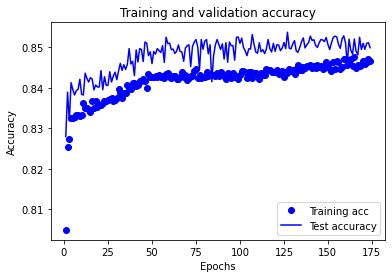

Model 1: Accuracy train 0.856 Accuracy test 0.852


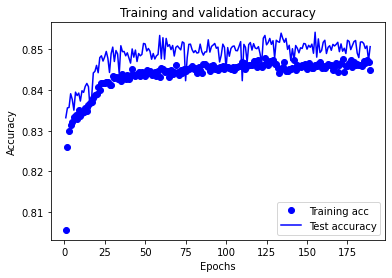

Model 2: Accuracy train 0.853 Accuracy test 0.851


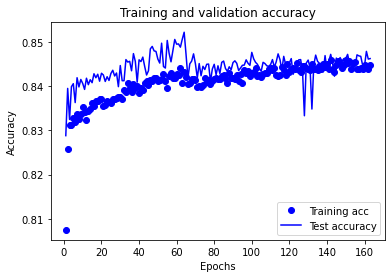

Model 3: Accuracy train 0.862 Accuracy test 0.854


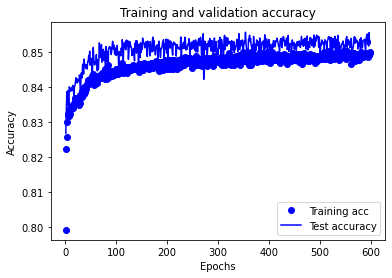

Model 4: Accuracy train 0.856 Accuracy test 0.849


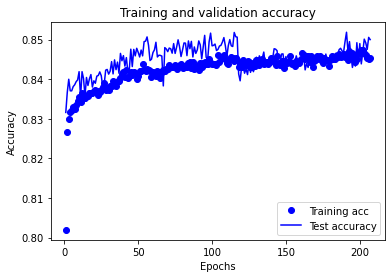

In [6]:
# Get data subgroups
subgroups = pd.read_csv('../data/subnet.csv', index_col='Item')
# Get list of clinical items
clinical_subgroup = subgroups.loc[subgroups['Subnet']=='clinical']
clinical_subgroup = list(clinical_subgroup.index)
# Get list of pathway items
pathway_subgroup = subgroups.loc[subgroups['Subnet']=='pathway']
pathway_subgroup = list(pathway_subgroup.index)
# Get list of hospital items
hospital_subgroup = subgroups.loc[subgroups['Subnet']=='hospital']
hospital_subgroup = list(hospital_subgroup.index)

# Loop through 5 k-folds
test_acc = []

for k in range(5):
    
    # Load data
    train = pd.read_csv(f'../data/kfold_5fold/train_{k}.csv')
    test = pd.read_csv(f'../data/kfold_5fold/test_{k}.csv')
        
    # OneHot encode stroke team
    coded = pd.get_dummies(train['StrokeTeam'])
    train = pd.concat([train, coded], axis=1)
    train.drop('StrokeTeam', inplace=True, axis=1)
    coded = pd.get_dummies(test['StrokeTeam'])
    test = pd.concat([test, coded], axis=1)
    test.drop('StrokeTeam', inplace=True, axis=1)
    
    # Split into X, y
    X_train_df = train.drop('S2Thrombolysis',axis=1) 
    y_train_df = train['S2Thrombolysis']
    X_test_df = test.drop('S2Thrombolysis',axis=1) 
    y_test_df = test['S2Thrombolysis'] 
    
    # Split train and test data by subgroups
    X_train_patients = X_train_df[clinical_subgroup]
    X_test_patients = X_test_df[clinical_subgroup]
    X_train_pathway = X_train_df[pathway_subgroup]
    X_test_pathway = X_test_df[pathway_subgroup]
    X_train_hospitals = X_train_df[hospital_subgroup]
    X_test_hospitals = X_test_df[hospital_subgroup]
            
    # Convert to NumPy
    X_train = X_train_df.values
    X_test = X_test_df.values
    y_train = y_train_df.values
    y_test = y_test_df.values
    
    # Scale data
    X_train_patients_sc, X_test_patients_sc = \
        scale_data(X_train_patients, X_test_patients)

    X_train_pathway_sc, X_test_pathway_sc = \
        scale_data(X_train_pathway, X_test_pathway)

    X_train_hospitals_sc, X_test_hospitals_sc = \
        scale_data(X_train_hospitals, X_test_hospitals)

    # Define network
    number_features_patient = X_train_patients_sc.shape[1]
    number_features_pathway = X_train_pathway_sc.shape[1]
    number_features_hospital = X_train_hospitals_sc.shape[1]

    model = make_net(
        number_features_patient, 
        number_features_pathway, 
        number_features_hospital)
    
    # Define save checkpoint callback (only save if new best validation results)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        'model_checkpoint_2d.h5', save_best_only=True)
    
    # Define early stopping callback: Stop when no validation improvement
    # Restore weights to best validation accuracy
    early_stopping_cb = keras.callbacks.EarlyStopping(
        patience=100, restore_best_weights=True)
    
    # Train model (including class weights)
    history = model.fit(
        [X_train_patients_sc, X_train_pathway_sc, X_train_hospitals_sc],
        y_train,
        epochs=5000,
        batch_size=32,
        validation_data=(
            [X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc], 
            y_test),
        verbose=0,
        callbacks=[checkpoint_cb, early_stopping_cb])
    
    ### Test model
    probability = model.predict(
        [X_train_patients_sc, X_train_pathway_sc, X_train_hospitals_sc])
    y_pred_train = probability >= 0.5
    y_pred_train = y_pred_train.flatten()
    accuracy_train = np.mean(y_pred_train == y_train)
    print(f'Model {k}: Accuracy train {accuracy_train:0.3f}', end=' ')
    
    probability = model.predict(
        [X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc])
    y_pred_test = probability >= 0.5
    y_pred_test = y_pred_test.flatten()
    accuracy_test = np.mean(y_pred_test == y_test)
    print(f'Accuracy test {accuracy_test:0.3f}')
    
    # save model
    filename = f'{path}model_{str(k)}.h5'
    model.save(filename);
    
    # Plot training accuracy
    history_dict = history.history

    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    test_acc.append(val_acc_values)
    epochs = range(1, len(acc_values) + 1)

    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
    # Remove model
    del model